<a href="https://colab.research.google.com/github/nomnomnonono/Image-Completion/blob/main/GLCIC/GLCIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sun Jan 16 02:12:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## ライブラリの読み込み

In [4]:
import sys
sys.path.append("/content/drive/MyDrive/experiment/final")

In [5]:
import torch
from torch.nn import BCELoss, DataParallel
from torch.nn.functional import mse_loss
from torch.optim import Adadelta, Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

from PIL import Image
import joblib
import json
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc

from datasets import ImageDataset
from models import CompletionNetwork, ContextDiscriminator
from tools import crop, define_hole_area, generate_mask, generate_multiple_mask, generate_circle_mask, get_completion_image, sample_random_batch
from sfloss import SpatialFrequencyLoss

## 初期設定

In [6]:
data_dir = "img_align_celeba"
result_dir = "/content/drive/MyDrive/experiment/final/result"
recursive_search = False
data_parallel = False
device = torch.device('cuda')
cn_input_size = 120
ld_input_size = 72
hole_min_w = 36
hole_max_w = 72
hole_min_h = 36
hole_max_h = 72
n_holes = 4
radius_min = 18
radius_max = 36
steps1 = 90000
steps2 = 10000
steps3 = 400000
steps4 = 100000
steps4_2 = 100000
snaperiod1 = 10000
snaperiod2 = 1000
snaperiod3 = 10000
snaperiod4 = 10000
snaperiod4_2 = 10000
bsize = 16
bdivs = 1
alpha = 4e-4
num_test_completions = 16

## 画像の読み込み

In [7]:
!mkdir train test

In [8]:
!cp "/content/drive/MyDrive/experiment/final/img_align_celeba.zip" "."
!unzip -q img_align_celeba.zip
!mv img_align_celeba/2* test/

In [9]:
# Number of Images
!ls "img_align_celeba" -1 | wc -l
!ls "test" -1 | wc -l

199999
2600


In [10]:
if not os.path.exists(result_dir):
        os.makedirs(result_dir)
for phase in ['phase_1', 'phase_2', 'phase_3']:
    if not os.path.exists(os.path.join(result_dir, phase)):
        os.makedirs(os.path.join(result_dir, phase))

## データセット

In [11]:
transform = transforms.Compose([
        transforms.Resize(cn_input_size),
        transforms.RandomCrop((cn_input_size, cn_input_size)),
        transforms.ToTensor(),
])

train = ImageDataset('img_align_celeba', transform, recursive_search=recursive_search)
train_loader = DataLoader(train, batch_size=bsize//bdivs, shuffle=True)
test = ImageDataset('test', transform, recursive_search=recursive_search)

## mpvの計算・読み込み

In [ ]:
mpv = np.zeros(shape=(3,))
pbar = tqdm(total=len(train.imgpaths),
            desc='computing mean pixel value')
for img_path in train.imgpaths:
  img = Image.open(img_path)
  x = np.array(img).astype('float32') / 255.
  mpv += x.mean(axis=(0, 1))
  pbar.update()
mpv /= len(train.imgpaths)
pbar.close

computing mean pixel value: 100%|█████████▉| 199950/199999 [06:26<00:00, 525.50it/s]

<bound method tqdm.close of <tqdm.std.tqdm object at 0x7fda5bfef3d0>>

In [12]:
mpv_json = open(os.path.join(result_dir, 'config.json'), 'r')
mpv_data = json.load(mpv_json)
mpv = mpv_data['mpv']
mpv = np.array(mpv)

In [13]:
mpv = torch.tensor(mpv.reshape(1, 3, 1, 1), dtype=torch.float32).to(device)
alpha = torch.tensor(alpha, dtype=torch.float32).to(device)

## Training with MSE

### Phase 1
pre-train Generator  4h

In [ ]:
model_cn = CompletionNetwork()
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss = []

In [ ]:
cnt_bdivs = 0
pbar = tqdm(total=steps1)

while pbar.n < steps1:
  for x in train_loader:
    # forward
    x = x.to(device)
    mask = generate_multiple_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=((hole_min_w, hole_max_w),
                   (hole_min_h, hole_max_h)),
        hole_area=define_hole_area(
            (ld_input_size, ld_input_size),
            (x.shape[3], x.shape[2])
        )[0],
        n_holes=1
    ).to(device)
    x_mask = x - x * mask + mpv * mask
    input = torch.cat((x_mask, mask), dim=1)
    output = model_cn(input)
    loss = mse_loss(x*mask, output*mask)
    G_loss.append(loss)

    # backward
    loss.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description('phase 1 | train loss: %.5f' % loss.cpu())
      pbar.update()

      # test
      if pbar.n % snaperiod1 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_multiple_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=((hole_min_w, hole_max_w),
                         (hole_min_h, hole_max_h)),
              hole_area=define_hole_area(
              (ld_input_size, ld_input_size),
              (x.shape[3], x.shape[2])
              )[0],
              n_holes=1
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          # 結果とモデルの保存
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          img_path = os.path.join(
              result_dir, 'phase_1', 'step%d.jpg' % (pbar.n)
          )
          save_image(imgs, img_path, nrow=len(x))
          model_cn_path = os.path.join(
              result_dir, 'phase_1', 'step%d.pth' % (pbar.n)
          )
          torch.save(
              model_cn.state_dict(),
              model_cn_path
          )
        model_cn.train()
      if pbar.n >= steps1:
        break
    break
pbar.close()

phase 1 | train loss: 0.01534:   0%|          | 7/90000 [00:10<38:49:39,  1.55s/it]
phase 1 | train loss: 0.00270: 100%|██████████| 90000/90000 [4:21:38<00:00,  5.73it/s]


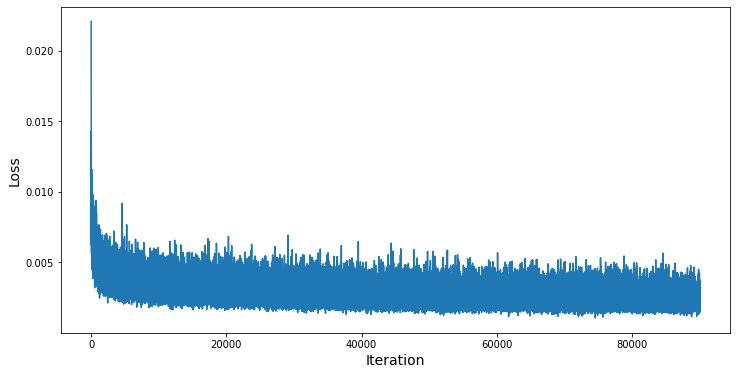

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(G_loss)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
fig.savefig(os.path.join(result_dir, 'phase_1', 'G_loss90000.png'))

In [ ]:
joblib.dump(G_loss, os.path.join(result_dir, 'phase_1', 'G_loss90000.txt'))

['/content/drive/MyDrive/experiment/final/result/phase_1/G_loss90000.txt']

### Phase2
pre-train Discriminator  0.5h

In [ ]:
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss = []

In [ ]:
cnt_bdivs = 0
pbar = tqdm(total=steps2)
while pbar.n < steps2:
  for x in train_loader:
    x = x.to(device)
    # fake forward
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    mask = generate_mask(
        shape=(
            x.shape[0], 1, x.shape[2], x.shape[3]
        ),
        hole_size=(
            (hole_min_w, hole_max_w), (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0]
    ).to(device)
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((
        input_ld_fake.to(device),
        input_gd_fake.to(device)))
    loss_fake = loss_cd(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_real = loss_cd(output_real, real)

    loss = (loss_fake + loss_real) / 2
    D_loss.append(loss)

    # backward
    loss.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      opt_cd.step()
      opt_cd.zero_grad()
      pbar.set_description('phase 2 | train loss: %.5f' % loss.cpu())
      pbar.update()

      # test
      if pbar.n % snaperiod2 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(test, batch_size=num_test_completions).to(device)
          mask = generate_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=((hole_min_w, hole_max_w),
                         (hole_min_h, hole_max_h)),
              hole_area=define_hole_area(
              (ld_input_size, ld_input_size),
              (x.shape[3], x.shape[2])
              )[0]
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          img_path = os.path.join(
              result_dir, 'phase_2', 'step%d.jpg' % (pbar.n)
          )
          save_image(imgs, img_path, nrow=len(x))
          model_path = os.path.join(
              result_dir, 'phase_2', 'step%d.pth' % (pbar.n)
          )
          torch.save(model_cd.state_dict(), model_path)
        model_cn.train()
      if pbar.n >= steps2:
        break
pbar.close()

phase 2 | train loss: 0.00000: 100%|██████████| 10000/10000 [24:39<00:00,  6.76it/s]


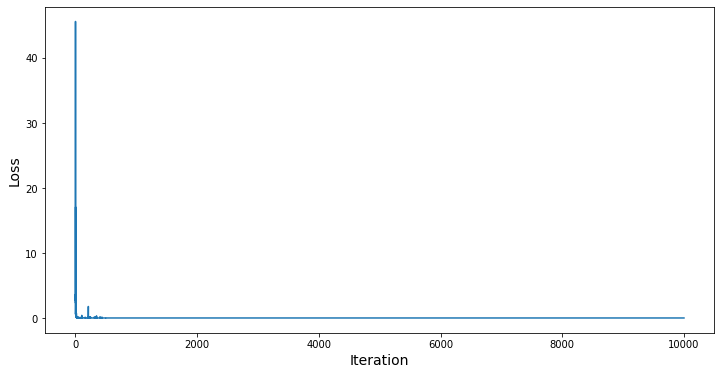

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(D_loss)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
fig.savefig(os.path.join(result_dir, 'phase_2', 'D_loss10000.png'))

In [ ]:
joblib.dump(D_loss, os.path.join(result_dir, 'phase_2', 'D_loss10000.txt'))

['/content/drive/MyDrive/experiment/final/result/phase_2/D_loss10000.txt']

### Phase3
train Generator & Discriminator

In [ ]:
path_model_cn = os.path.join(result_dir, 'phase_3', 'cn_step290000.pth')
path_model_cd = os.path.join(result_dir, 'phase_3', 'cd_step290000.pth')

In [ ]:
model_cn = CompletionNetwork()
model_cn.load_state_dict(torch.load(path_model_cn, map_location='cpu'))
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss3 = []

model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd.load_state_dict(torch.load(path_model_cd, map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss3 = []

In [ ]:
cnt_bdivs = 0
bceloss = BCELoss()
pbar =tqdm(total=steps3)

while pbar.n < steps3:
  for x in train_loader:
    ## forward model_cd
    x = x.to(device)
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2]))
    mask = generate_multiple_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=(
            (hole_min_w, hole_max_w),
            (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0],
        n_holes=1
    ).to(device)
    # fake forward
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cd_fake = bceloss(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_cd_real = bceloss(output_real, real)
    ## backward model_cd
    loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.
    D_loss3.append(loss_cd)
    loss_cd.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      # optimize
      opt_cd.step()
      opt_cd.zero_grad()
    ## forward model_cn
    loss_cn_1 = mse_loss(x*mask, output_cn*mask)
    input_gd_fake = output_cn
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cn_2 = bceloss(output_fake, real)
    ## backward model_cn
    loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.
    G_loss3.append(loss_cn)
    loss_cn.backward()
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      # optimize
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description(
          'phase3 | train loss (cd): %.5f (cn): %5.f' % (
              loss_cd.cpu(),
              loss_cn.cpu()
          )
      )
      pbar.update()
      ## test
      if pbar.n % snaperiod3 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_multiple_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=(
                  (hole_min_w, hole_max_w),
                  (hole_min_h, hole_max_h)
              ),
              hole_area=define_hole_area(
                  (ld_input_size, ld_input_size),
                  (x.shape[3], x.shape[2])
              )[0],
              n_holes=1
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          imgpath = os.path.join(
              result_dir, 'phase_3', 'step%d.png' % (pbar.n)
          )
          model_cn_path = os.path.join(
              result_dir, 'phase_3', 'cn_step%d.pth' % (pbar.n)
          )
          model_cd_path = os.path.join(
              result_dir, 'phase_3', 'cd_step%d.pth' % (pbar.n)
          )
          save_image(imgs, imgpath, nrow=len(x))
          torch.save(model_cn.state_dict(), model_cn_path)
          torch.save(model_cd.state_dict(), model_cd_path)
          joblib.dump(D_loss3, os.path.join(result_dir, 'phase_3', 'D_loss%d.txt' % (pbar.n)))
          joblib.dump(G_loss3, os.path.join(result_dir, 'phase_3', 'G_loss%d.txt' % (pbar.n)))
          del D_loss3, G_loss3
          gc.collect()
          D_loss3 = []
          G_loss3 = []
        model_cn.train()
      if pbar.n >= steps3:
        break;
pbar.close()

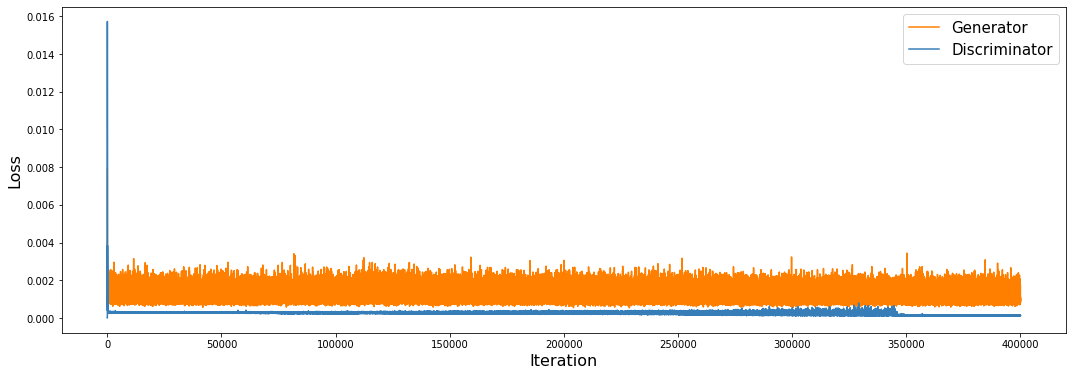

In [ ]:
fig = plt.figure(figsize=(18,6))
plt.plot(G_loss3, label='Generator', color="#ff7f00")
plt.plot(D_loss3, label='Discriminator', color="#377eb8")
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=15)
fig.savefig(os.path.join(result_dir, 'phase_3', 'DG_loss500000.png'))

### Phase4
train Generator & Discriminator with multiple holes

In [ ]:
if not os.path.exists(os.path.join(result_dir, 'phase_4')):
  os.makedirs(os.path.join(result_dir, 'phase_4'))

In [ ]:
model_cn = CompletionNetwork()
model_cn.load_state_dict(torch.load(os.path.join(result_dir, 'phase_4', 'cn_step50000.pth'), map_location='cpu'))
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss4 = []
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd.load_state_dict(torch.load(os.path.join(result_dir, 'phase_4', 'cd_step50000.pth'), map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss4 = []

In [ ]:
cnt_bdivs = 0
bceloss = BCELoss()
pbar =tqdm(total=steps4//2)

while pbar.n < steps4//2:
  for x in train_loader:
    ## forward model_cd
    x = x.to(device)
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    mask = generate_multiple_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=(
            (hole_min_w, hole_max_w),
            (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0],
        n_holes=4
    ).to(device)
    # fake forward
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cd_fake = bceloss(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_cd_real = bceloss(output_real, real)
    ## backward model_cd
    loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.
    D_loss4.append(loss_cd)
    loss_cd.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      # optimize
      opt_cd.step()
      opt_cd.zero_grad()
    ## forward model_cn
    loss_cn_1 = mse_loss(x*mask, output_cn*mask)
    input_gd_fake = output_cn
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cn_2 = bceloss(output_fake, real)
    ## backward model_cn
    loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.
    G_loss4.append(loss_cn)
    loss_cn.backward()
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      # optimize
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description(
          'phase4 | train loss (cd): %.5f (cn): %5.f' % (
              loss_cd.cpu(),
              loss_cn.cpu()
          )
      )
      pbar.update()
      ## test
      if pbar.n % snaperiod4 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_multiple_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=(
                  (hole_min_w, hole_max_w),
                  (hole_min_h, hole_max_h)
              ),
              hole_area=define_hole_area(
                  (ld_input_size, ld_input_size),
                  (x.shape[3], x.shape[2])
              )[0],
              n_holes=n_holes
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          imgpath = os.path.join(
              result_dir, 'phase_4', 'step%d.png' % (pbar.n+50000)
          )
          model_cn_path = os.path.join(
              result_dir, 'phase_4', 'cn_step%d.pth' % (pbar.n+50000)
          )
          model_cd_path = os.path.join(
              result_dir, 'phase_4', 'cd_step%d.pth' % (pbar.n+50000)
          )
          save_image(imgs, imgpath, nrow=len(x))
          torch.save(model_cn.state_dict(), model_cn_path)
          torch.save(model_cd.state_dict(), model_cd_path)
        model_cn.train()
      if pbar.n >= steps4//2:
        break;
pbar.close()

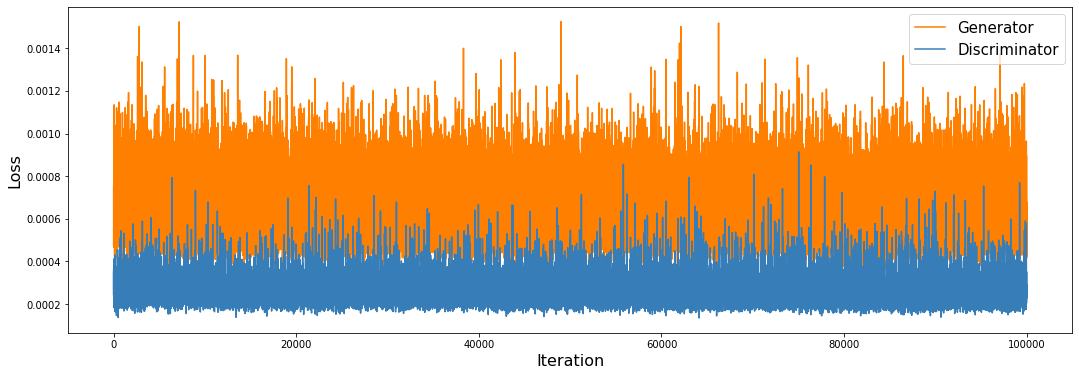

In [ ]:
fig = plt.figure(figsize=(18,6))
plt.plot(G_loss4, label='Generator', color="#ff7f00")
plt.plot(D_loss4, label='Discriminator', color="#377eb8")
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=15)
fig.savefig(os.path.join(result_dir, 'phase_4', 'DG_loss100000.png'))

In [ ]:
joblib.dump(D_loss4, os.path.join(result_dir, 'phase_4', 'D_loss100000.txt'))
joblib.dump(G_loss4, os.path.join(result_dir, 'phase_4', 'G_loss100000.txt'))

['/content/drive/MyDrive/experiment/final/result/phase_4/G_loss100000.txt']

### Phase4-2
train Generator & Discriminator with multiple circle holes

In [ ]:
if not os.path.exists(os.path.join(result_dir, 'phase_4_2')):
  os.makedirs(os.path.join(result_dir, 'phase_4_2'))

In [ ]:
model_cn = CompletionNetwork()
#model_cn.load_state_dict(torch.load(os.path.join(result_dir, 'phase_3', 'cn_step500000.pth'), map_location='cpu'))
model_cn.load_state_dict(torch.load(os.path.join(result_dir, 'phase_4_2', 'cn_step50000.pth'), map_location='cpu'))
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss4_2 = []
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
#model_cd.load_state_dict(torch.load(os.path.join(result_dir, 'phase_3', 'cd_step500000.pth'), map_location='cpu'))
model_cd.load_state_dict(torch.load(os.path.join(result_dir, 'phase_4_2', 'cd_step50000.pth'), map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss4_2 = []

In [ ]:
cnt_bdivs = 0
bceloss = BCELoss()
pbar =tqdm(total=steps4_2)

while pbar.n < steps4_2:
  for x in train_loader:
    ## forward model_cd
    x = x.to(device)
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2]))
    mask = generate_circle_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        radius_range=(
            radius_min, radius_max
        ),
        hole_area=hole_area_fake[0],
        n_holes=n_holes
    ).to(torch.float32).to(device)
    # fake forward
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cd_fake = bceloss(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_cd_real = bceloss(output_real, real)
    ## backward model_cd
    loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.
    D_loss4_2.append(loss_cd)
    loss_cd.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      # optimize
      opt_cd.step()
      opt_cd.zero_grad()
    ## forward model_cn
    loss_cn_1 = mse_loss(x*mask, output_cn*mask)
    input_gd_fake = output_cn
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cn_2 = bceloss(output_fake, real)
    ## backward model_cn
    loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.
    G_loss4_2.append(loss_cn)
    loss_cn.backward()
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      # optimize
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description(
          'phase4 | train loss (cd): %.5f (cn): %5.f' % (
              loss_cd.cpu(),
              loss_cn.cpu()
          )
      )
      pbar.update()
      ## test
      if pbar.n % snaperiod4_2 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_circle_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              radius_range=(
                  radius_min, radius_max
              ),
              hole_area=define_hole_area(
                  (ld_input_size, ld_input_size),
                  (x.shape[3], x.shape[2])
              )[0],
              n_holes=n_holes
          ).to(torch.float32).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          imgpath = os.path.join(
              result_dir, 'phase_4_2', 'step%d.png' % (pbar.n)
          )
          model_cn_path = os.path.join(
              result_dir, 'phase_4_2', 'cn_step%d.pth' % (pbar.n)
          )
          model_cd_path = os.path.join(
              result_dir, 'phase_4_2', 'cd_step%d.pth' % (pbar.n)
          )
          save_image(imgs, imgpath, nrow=len(x))
          torch.save(model_cn.state_dict(), model_cn_path)
          torch.save(model_cd.state_dict(), model_cd_path)
        model_cn.train()
      if pbar.n >= steps4_2:
        break;
pbar.close()

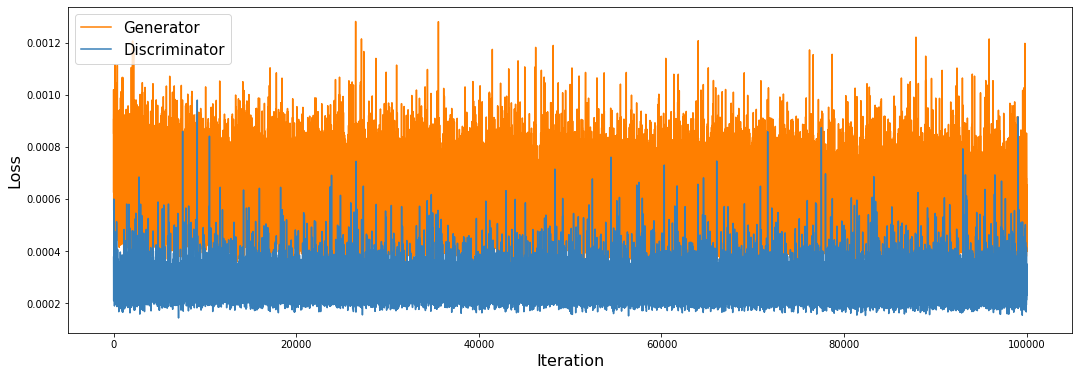

In [ ]:
fig = plt.figure(figsize=(18,6))
plt.plot(G_loss4_2, label='Generator', color="#ff7f00")
plt.plot(D_loss4_2, label='Discriminator', color="#377eb8")
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=15)
fig.savefig(os.path.join(result_dir, 'phase_4_2', 'DG_loss100000.png'))

In [ ]:
joblib.dump(D_loss4_2, os.path.join(result_dir, 'phase_4_2', 'D_loss100000.txt'))
joblib.dump(G_loss4_2, os.path.join(result_dir, 'phase_4_2', 'G_loss100000.txt'))

['/content/drive/MyDrive/experiment/final/result/phase_4_2/G_loss100000.txt']

## Training with sfloss

In [14]:
sf_loss = SpatialFrequencyLoss(3)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Phase 1
pre-train Generator  10000iter: 1h40min

In [15]:
model_cn = CompletionNetwork()
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss = []

In [16]:
if not os.path.exists(os.path.join(result_dir, 'phase_1b')):
  os.mkdir(os.path.join(result_dir, 'phase_1b'))

In [27]:
cnt_bdivs = 0
pbar = tqdm(total=steps1)

while pbar.n < steps1:
  for x in train_loader:
    # forward
    x = x.to(device)
    mask = generate_multiple_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=((hole_min_w, hole_max_w),
                   (hole_min_h, hole_max_h)),
        hole_area=define_hole_area(
            (ld_input_size, ld_input_size),
            (x.shape[3], x.shape[2])
        )[0],
        n_holes=1
    ).to(device)
    x_mask = x - x * mask + mpv * mask
    input = torch.cat((x_mask, mask), dim=1)
    output = model_cn(input)
    loss = sf_loss(x*mask, output*mask)
    G_loss.append(loss.item())

    # backward
    loss.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description('phase 1b | train loss: %.5f' % loss.cpu())
      pbar.update()

      # test
      if pbar.n % snaperiod1 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_multiple_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=((hole_min_w, hole_max_w),
                         (hole_min_h, hole_max_h)),
              hole_area=define_hole_area(
              (ld_input_size, ld_input_size),
              (x.shape[3], x.shape[2])
              )[0],
              n_holes=1
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          # 結果とモデルの保存
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          img_path = os.path.join(
              result_dir, 'phase_1b', 'step%d.png' % (pbar.n+20000)
          )
          save_image(imgs, img_path, nrow=len(x))
          model_cn_path = os.path.join(
              result_dir, 'phase_1b', 'step%d.pth' % (pbar.n+20000)
          )
          torch.save(
              model_cn.state_dict(),
              model_cn_path
          )
        model_cn.train()
      if pbar.n >= steps1:
        break
    break
pbar.close()

phase 1b | train loss: 0.36508:   0%|          | 2/90000 [00:26<327:55:17, 13.12s/it]
phase 1b | train loss: 0.34514:  11%|█         | 10089/90000 [1:48:16<14:22:07,  1.54it/s]

KeyboardInterrupt: ignored

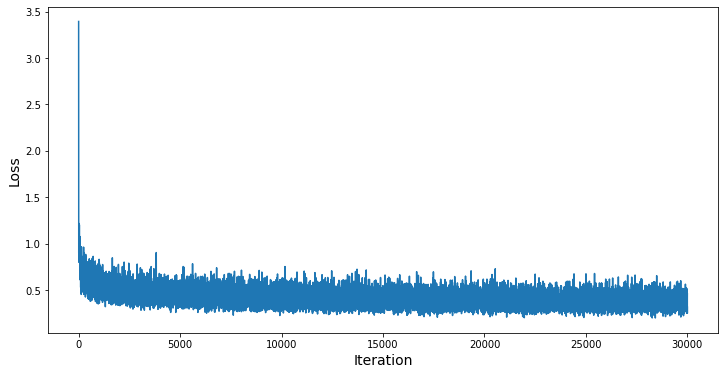

In [32]:
fig = plt.figure(figsize=(12,6))
plt.plot(G_loss)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
fig.savefig(os.path.join(result_dir, 'phase_1b', 'G_loss30000.png'))

In [33]:
joblib.dump(G_loss, os.path.join(result_dir, 'phase_1b', 'G_loss30000.txt'))

['/content/drive/MyDrive/experiment/final/result/phase_1b/G_loss30000.txt']

### Phase 2
pre-train Discriminator

In [34]:
if not os.path.exists(os.path.join(result_dir, 'phase_2b')):
  os.mkdir(os.path.join(result_dir, 'phase_2b'))

In [43]:
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss = []

In [44]:
cnt_bdivs = 0
pbar = tqdm(total=steps2)
while pbar.n < steps2:
  for x in train_loader:
    x = x.to(device)
    # fake forward
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    mask = generate_multiple_mask(
        shape=(
            x.shape[0], 1, x.shape[2], x.shape[3]
        ),
        hole_size=(
            (hole_min_w, hole_max_w), (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0],
        n_holes=1
    ).to(device)
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((
        input_ld_fake.to(device),
        input_gd_fake.to(device)))
    loss_fake = loss_cd(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_real = loss_cd(output_real, real)

    loss = (loss_fake + loss_real) / 2
    D_loss.append(loss)

    # backward
    loss.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      opt_cd.step()
      opt_cd.zero_grad()
      pbar.set_description('phase 2b | train loss: %.5f' % loss.cpu())
      pbar.update()

      # test
      if pbar.n % snaperiod2 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(test, batch_size=num_test_completions).to(device)
          mask = generate_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=((hole_min_w, hole_max_w),
                         (hole_min_h, hole_max_h)),
              hole_area=define_hole_area(
              (ld_input_size, ld_input_size),
              (x.shape[3], x.shape[2])
              )[0]
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          img_path = os.path.join(
              result_dir, 'phase_2b', 'step%d.png' % (pbar.n)
          )
          save_image(imgs, img_path, nrow=len(x))
          model_path = os.path.join(
              result_dir, 'phase_2b', 'step%d.pth' % (pbar.n)
          )
          torch.save(model_cd.state_dict(), model_path)
        model_cn.train()
      if pbar.n >= steps2:
        break
pbar.close()

phase 2b | train loss: 0.11710:   0%|          | 26/10000 [00:29<3:05:53,  1.12s/it]
phase 2b | train loss: 0.00000: 100%|██████████| 10000/10000 [25:10<00:00,  6.62it/s]


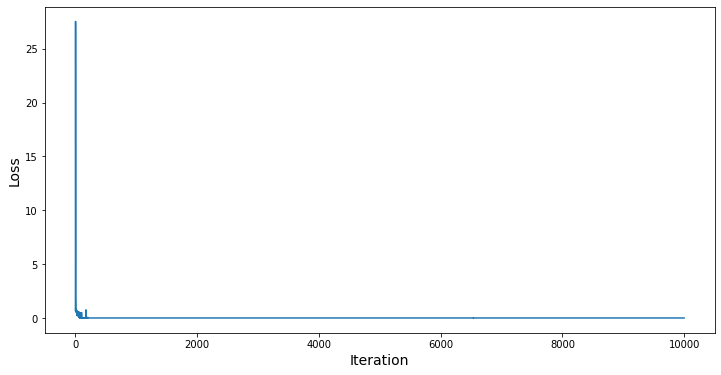

In [47]:
fig = plt.figure(figsize=(12, 6))
plt.plot(D_loss)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
fig.savefig(os.path.join(result_dir, 'phase_2b', 'D_loss10000.png'))

In [ ]:
joblib.dump(D_loss, os.path.join(result_dir, 'phase_2b', 'D_loss10000.txt'))

### Phase 3
train Discriminator & Generator  10000iter: 2h

In [52]:
if not os.path.exists(os.path.join(result_dir, 'phase_3b')):
  os.mkdir(os.path.join(result_dir, 'phase_3b'))

In [64]:
path_model_cn = os.path.join(result_dir, 'phase_3b', 'cn_step10000.pth')
path_model_cd = os.path.join(result_dir, 'phase_3b', 'cd_step10000.pth')

In [67]:
model_cn = CompletionNetwork()
model_cn.load_state_dict(torch.load(path_model_cn, map_location='cpu'))
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss3 = []

model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd.load_state_dict(torch.load(path_model_cd, map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss3 = []

In [68]:
cnt_bdivs = 0
bceloss = BCELoss()
pbar =tqdm(total=50000)

while pbar.n < 50000:
  for x in train_loader:
    ## forward model_cd
    x = x.to(device)
    hole_area_fake = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2]))
    mask = generate_multiple_mask(
        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
        hole_size=(
            (hole_min_w, hole_max_w),
            (hole_min_h, hole_max_h)
        ),
        hole_area=hole_area_fake[0],
        n_holes=1
    ).to(device)
    # fake forward
    fake = torch.zeros((len(x), 1)).to(device)
    x_mask = x - x * mask + mpv * mask
    input_cn = torch.cat((x_mask, mask), dim=1)
    output_cn = model_cn(input_cn)
    input_gd_fake = output_cn.detach()
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cd_fake = bceloss(output_fake, fake)
    # real forward
    hole_area_real = define_hole_area(
        (ld_input_size, ld_input_size),
        (x.shape[3], x.shape[2])
    )
    real = torch.ones((len(x), 1)).to(device)
    input_gd_real = x
    input_ld_real = crop(input_gd_real, hole_area_real)
    output_real = model_cd((input_ld_real, input_gd_real))
    loss_cd_real = bceloss(output_real, real)
    ## backward model_cd
    loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.
    D_loss3.append(loss_cd)
    loss_cd.backward()
    cnt_bdivs += 1
    if cnt_bdivs >= bdivs:
      # optimize
      opt_cd.step()
      opt_cd.zero_grad()
    ## forward model_cn
    loss_cn_1 = sf_loss(x*mask, output_cn*mask)
    input_gd_fake = output_cn
    input_ld_fake = crop(input_gd_fake, hole_area_fake)
    output_fake = model_cd((input_ld_fake, input_gd_fake))
    loss_cn_2 = bceloss(output_fake, real)
    ## backward model_cn
    loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.
    G_loss3.append(loss_cn)
    loss_cn.backward()
    if cnt_bdivs >= bdivs:
      cnt_bdivs = 0
      # optimize
      opt_cn.step()
      opt_cn.zero_grad()
      pbar.set_description(
          'phase3b | train loss (cd): %.5f (cn): %5.f' % (
              loss_cd.cpu(),
              loss_cn.cpu()
          )
      )
      pbar.update()
      ## test
      if pbar.n % snaperiod3 == 0:
        model_cn.eval()
        with torch.no_grad():
          x = sample_random_batch(
              test,
              batch_size=num_test_completions
          ).to(device)
          mask = generate_multiple_mask(
              shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
              hole_size=(
                  (hole_min_w, hole_max_w),
                  (hole_min_h, hole_max_h)
              ),
              hole_area=define_hole_area(
                  (ld_input_size, ld_input_size),
                  (x.shape[3], x.shape[2])
              )[0],
              n_holes=1
          ).to(device)
          x_mask = x - x * mask + mpv * mask
          input = torch.cat((x_mask, mask), dim=1)
          output = model_cn(input)
          completed = get_completion_image(x, output, mask)
          imgs = torch.cat((
              x.cpu(),
              x_mask.cpu(),
              completed.cpu()
          ), dim=0)
          imgpath = os.path.join(
              result_dir, 'phase_3b', 'step%d.png' % (pbar.n+20000)
          )
          model_cn_path = os.path.join(
              result_dir, 'phase_3b', 'cn_step%d.pth' % (pbar.n+20000)
          )
          model_cd_path = os.path.join(
              result_dir, 'phase_3b', 'cd_step%d.pth' % (pbar.n+20000)
          )
          save_image(imgs, imgpath, nrow=len(x))
          torch.save(model_cn.state_dict(), model_cn_path)
          torch.save(model_cd.state_dict(), model_cd_path)
          joblib.dump(D_loss3, os.path.join(result_dir, 'phase_3b', 'D_loss%d.txt' % (pbar.n+20000)))
          joblib.dump(G_loss3, os.path.join(result_dir, 'phase_3b', 'G_loss%d.txt' % (pbar.n+20000)))
          del D_loss3, G_loss3
          gc.collect()
          D_loss3 = []
          G_loss3 = []
        model_cn.train()
      if pbar.n >= 50000:
        break;
pbar.close()

phase3b | train loss (cd): 0.00019 (cn):     0:   0%|          | 3/10000 [00:08<8:08:52,  2.93s/it]
phase3b | train loss (cd): 0.00015 (cn):     0: 100%|██████████| 10000/10000 [2:03:33<00:00,  1.35it/s]


In [71]:
for i in range(1, 3):
  g = joblib.load(os.path.join(result_dir, 'phase_3b', 'G_loss%d.txt' % (10000*i)))
  d = joblib.load(os.path.join(result_dir, 'phase_3b', 'D_loss%d.txt' % (10000*i)))
  G_loss3 = G_loss3 + g
  D_loss3 = D_loss3 + d

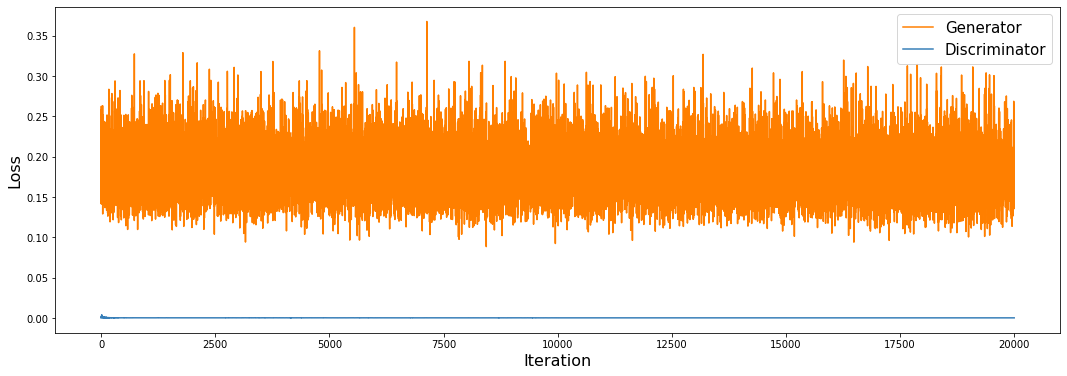

In [73]:
fig = plt.figure(figsize=(18,6))
plt.plot(G_loss3, label='Generator', color="#ff7f00")
plt.plot(D_loss3, label='Discriminator', color="#377eb8")
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=15)
#fig.savefig(os.path.join(result_dir, 'phase_3', 'DG_loss500000.png'))

### Phase 4
train with multiple circle hole

In [ ]:
if not os.path.exists(os.path.join(result_dir, 'phase_4b')):
  os.mkdir(os.path.join(result_dir, 'phase_4b'))

In [ ]:
path_model_cn = os.path.join(result_dir, 'phase_3b', 'cn_step30000.pth')
path_model_cd = os.path.join(result_dir, 'phase_3b', 'cd_step10000.pth')

In [ ]:
model_cn = CompletionNetwork()
model_cn.load_state_dict(torch.load(path_model_cn, map_location='cpu'))
model_cn = model_cn.to(device)
opt_cn = Adadelta(model_cn.parameters())
G_loss3 = []

model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size)
)
model_cd.load_state_dict(torch.load(path_model_cd, map_location='cpu'))
model_cd = model_cd.to(device)
opt_cd = Adadelta(model_cd.parameters())
loss_cd = BCELoss()
D_loss3 = []